In [1]:
!pip install fasttext --quiet
import os
import joblib
import fasttext.util
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
fasttext.util.download_model('pl', if_exists='ignore')
ft_model = fasttext.load_model('cc.pl.300.bin')

In [3]:
def get_ft_vector(text):
    cleaned_text = str(text).replace('\n', ' ').strip()
    return ft_model.get_sentence_vector(cleaned_text)

In [8]:
def load_and_embed(file_path):
    df = pd.read_csv(file_path)
    X = np.vstack(df['Text'].apply(get_ft_vector))
    y = df['Class'].values
    return X, y

In [ ]:
def train_evaluate_knn(X, y, param_grid, title="KNN_Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    clf = KNeighborsClassifier()
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📌 {title} – Najlepsze parametry:")
    print(grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    print(f"\n📊 Wyniki ({title}):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC:   {auc:.4f}")
    else:
        print("ROC AUC:   brak możliwości obliczenia (brak predict_proba)")

    print("\nConfusion Matrix:\n", cm)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    save_dir = f"{title}_results"
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title("Confusion Matrix for KNN - The Best Varian")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{title}_confusion_matrix.png"))
    plt.show()

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for KNN - The Best Varian")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{title}_roc_curve.png"))
        plt.show()

    model_path = os.path.join(save_dir, f"{title}.joblib")
    joblib.dump(best_model, model_path)
    print(f"✅ Model zapisany do: {model_path}")

In [9]:
X_raw, y_raw = load_and_embed('BAN-PL_raw.csv')
X_pre, y_pre = load_and_embed('BAN-PL_light.csv')
X_full, y_full = load_and_embed('BAN-PL_full.csv')

In [10]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan']
}

Fitting 4 folds for each of 14 candidates, totalling 56 fits

📌 KNN – Raw data – Najlepsze parametry:
{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.7829

📊 Wyniki (KNN – Raw data):
Accuracy:  0.7590
Precision: 0.7189
Recall:    0.8504
F1-score:  0.7792
ROC AUC:   0.8602

Confusion Matrix:
 [[1602  798]
 [ 359 2041]]

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.67      0.73      2400
           1       0.72      0.85      0.78      2400

    accuracy                           0.76      4800
   macro avg       0.77      0.76      0.76      4800
weighted avg       0.77      0.76      0.76      4800



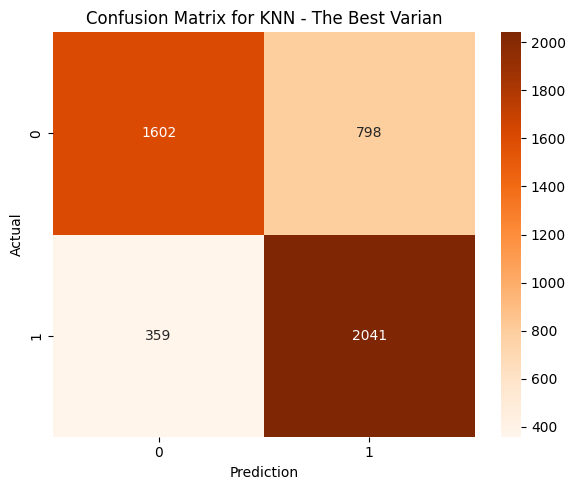

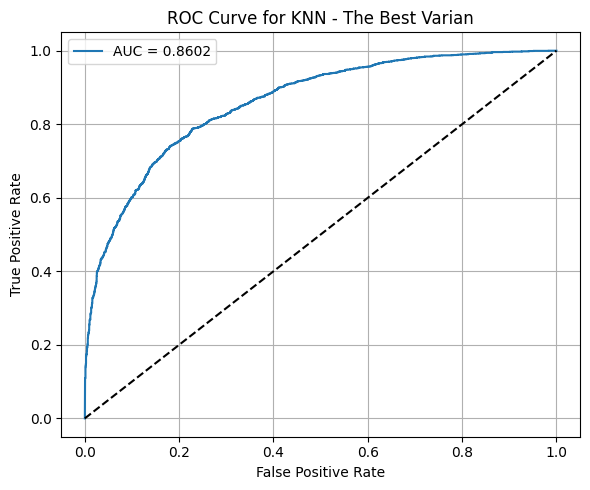

✅ Model zapisany do: KNN – Raw data_results/KNN – Raw data.joblib


In [11]:
train_evaluate_knn(X_raw, y_raw, param_grid_knn, title="KNN – Raw data")

Fitting 4 folds for each of 14 candidates, totalling 56 fits

📌 KNN – Preprocessed data – Najlepsze parametry:
{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.7829

📊 Wyniki (KNN – Preprocessed data):
Accuracy:  0.7725
Precision: 0.7318
Recall:    0.8598
F1-score:  0.7906
ROC AUC:   0.8637

Confusion Matrix:
 [[1644  755]
 [ 336 2060]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      2399
           1       0.73      0.86      0.79      2396

    accuracy                           0.77      4795
   macro avg       0.78      0.77      0.77      4795
weighted avg       0.78      0.77      0.77      4795



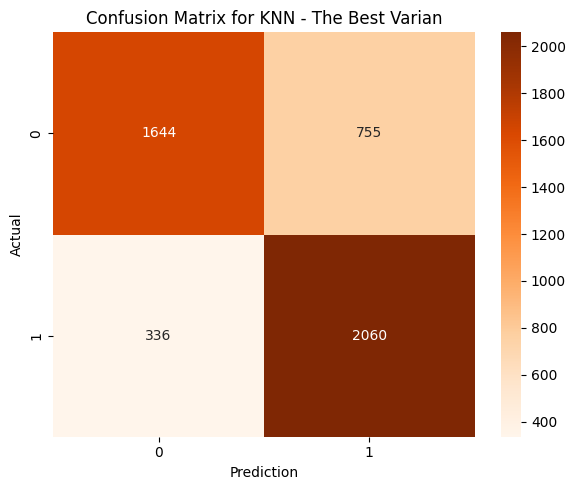

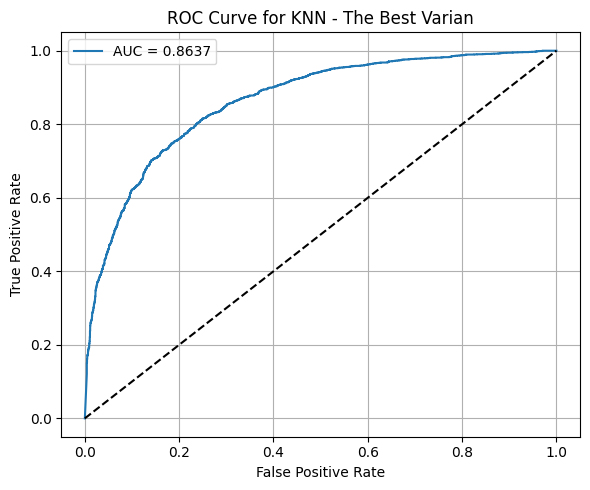

✅ Model zapisany do: KNN – Preprocessed data_results/KNN – Preprocessed data.joblib


In [12]:
train_evaluate_knn(X_pre, y_pre, param_grid_knn, title="KNN – Preprocessed data")

Fitting 4 folds for each of 14 candidates, totalling 56 fits

📌 KNN – Fully processed data – Najlepsze parametry:
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.7973

📊 Wyniki (KNN – Fully processed data):
Accuracy:  0.7820
Precision: 0.7338
Recall:    0.8855
F1-score:  0.8026
ROC AUC:   0.8811

Confusion Matrix:
 [[1622  769]
 [ 274 2120]]

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.68      0.76      2391
           1       0.73      0.89      0.80      2394

    accuracy                           0.78      4785
   macro avg       0.79      0.78      0.78      4785
weighted avg       0.79      0.78      0.78      4785



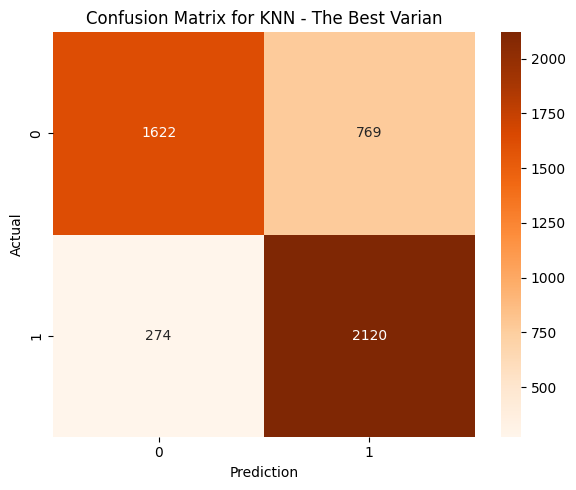

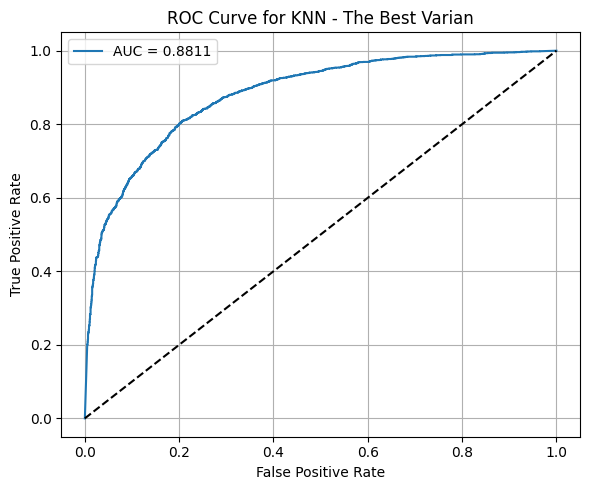

✅ Model zapisany do: KNN – Fully processed data_results/KNN – Fully processed data.joblib


In [13]:
train_evaluate_knn(X_full, y_full, param_grid_knn, title="KNN – Fully processed data")